In [ ]:
import numpy as np
from keras.datasets import mnist
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
summary_df = pd.DataFrame({}, columns=['Parameter Network','Epoch Num', 'Num Iteration', 'Costs Train', 'Costs Validation', 'Train Accuracy', 'Validation Accuracy'])

In [ ]:
def initialize_parameters(layer_dims):
  '''
  Input:
    layer_dims: List of integers representing the dimensions of each layer in the neural network.

  Output:
  Returns a dictionary containing the randomly initialized parameters (weights and biases) for each layer.
  '''
  np.random.seed(24)
  para_dict = {}
  for i in range(1, len(layer_dims)):
     para_dict["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1])/layer_dims[i-1]
     para_dict["b" + str(i)] = np.zeros((layer_dims[i], 1))
  return para_dict

def linear_forward(A,W,b):
  '''
  Input:
    A: Input matrix (activations) from the previous layer.
    W: Weight matrix for the current layer.
    b: Bias vector for the current layer.

  Output:
    Returns the linear combination (Z) of input, and a cache dictionary storing input values for later use in backpropagation.
  '''
  Z = np.dot(W,A) + b
  linear_cache = {'A': A, 'W': W, 'b': b}
  return Z, linear_cache


def softmax(Z):
  '''
  Input:
    Z: The linear component of the activation function.

  Output:
    Returns the softmax activation and the linear component Z, useful for backpropagation.
  '''
  z_i = np.exp(Z - np.max(Z,axis=0, keepdims=True))
  softmax_output = z_i / np.sum(z_i,axis=0, keepdims=True)
  return softmax_output, Z


def relu(Z):
  '''
  Input:
    Z: The linear component of the activation function.

  Output:
    Returns the ReLU activation and the linear component Z, useful for backpropagation.
  '''
  a = np.maximum(Z, 0)
  return a, Z


def linear_activation_forward(A_prev,W,B, activation):
  '''
  Input:
    A_prev: Activations from the previous layer.
    W: Weight matrix for the current layer.
    B: Bias vector for the current layer.
    activation: Activation function to be used ('relu' or 'softmax').

  Output:
    Returns the activations for the current layer and caches for later use in backpropagation.
  '''

  z, linear_cache = linear_forward(A_prev,W,B)
  if activation == "relu":
    A, activation_cache = relu(z)
  else:
    A, activation_cache = softmax(z)
  caches = (linear_cache,activation_cache)
  return A, caches


def L_model_forward(X, parameters, use_batchnorm):
  '''
  Input:
    X: Input data.
    parameters: Dictionary containing the parameters for each layer.
    use_batchnorm: Boolean indicating whether to use batch normalization.
  Output:
    Returns the final output of the neural network and a list of caches for each layer.
  '''

  L = len(parameters) // 2
  caches = []

  prev_input = X
  for i in range(1,L):
    w = parameters["W" + str(i)]
    b = parameters["b" + str(i)]
    input ,linear_cache = linear_activation_forward(prev_input,w,b, "relu")
    caches.append(linear_cache)
    if use_batchnorm is True:
      input = apply_batchnorm(input)
    prev_input = input
  w = parameters["W" + str(L)]
  b = parameters["b" + str(L)]
  input ,linear_cache = linear_activation_forward(prev_input,w,b, "softmax")
  caches.append(linear_cache)
  return input, caches

def compute_cost(AL, Y, parameters,lambd=0):
  '''
  Input:
    AL: Output of the neural network.
    Y: True labels.
    parameters: Dictionary containing the parameters for each layer.
    lambd: Regularization parameter for L2 regularization (default is 0).

  Output:
    Returns the computed cost, considering categorical cross-entropy loss and L2 regularization.
  '''

  m = Y.shape[1]
  AL = np.maximum(AL, 1e-15)
  cost = -1/m * np.sum(Y * np.log(AL))
  L2_regularization_cost = lambd/(2*m) * sum(np.sum(np.square(parameters[f'W{i}'])) for i in range(1, len(parameters) // 2 + 1))
  cost = cost + L2_regularization_cost
  return cost

def apply_batchnorm(A):
  '''
  Input:
    A: Input matrix to be normalized.

  Output:
    Returns the batch-normalized version of the input matrix using mean and variance.
  '''
  epsilon = 1e-8
  mean = np.mean(A,axis = 0)
  var = np.var(A,axis = 0)
  norm_A = (A-mean)/(np.sqrt(var+epsilon))
  return norm_A


#Section 2

In [ ]:
def linear_backward(dZ, cache,lambd=0):
  '''
  Input:
    dZ: Gradient of the cost with respect to the linear output.
    cache: Dictionary containing the cached values (A, W, b) from the forward pass.
    lambd: Regularization parameter for L2 regularization (default is 0).

  Output:
    Returns gradients dA_prev, dW, and db with respect to the previous layer's activations, weight, and bias, respectively.

  '''

  A_prev = cache['A']
  m = A_prev.shape[1]
  W = cache['W']
  b = cache['b']
  dW = (np.dot(dZ,np.transpose(A_prev))) / m + (lambd/m)* cache["W"]
  db = (np.sum(dZ, axis=1,keepdims=True)) / m
  dA_prev = np.dot(np.transpose(W),dZ)
  return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation,lambd=0):
  '''
    Input:
      dA: Gradient of the cost with respect to the activation of the current layer.
      cache: Tuple containing linear_cache and activation_cache from the forward pass.
      activation: Activation function used in the layer ('relu' or 'softmax').
      lambd: Regularization parameter for L2 regularization (default is 0).

  Output:
    Returns gradients dA_prev, dW, and db with respect to the previous layer's activations, weight, and bias, respectively.
  '''

  linear_cache,activation_cache = cache
  if activation == "relu":
      dZ = relu_backward(dA, activation_cache)
  else:
      dZ = softmax_backward(dA, activation_cache)
  return linear_backward(dZ, linear_cache,lambd)

def relu_backward(dA, activation_cache):
  '''
  Input:
    dA: Gradient of the cost with respect to the activation of the current layer.
    activation_cache: Cache containing the linear component Z from the forward pass.

  Output:
    Returns the gradient dZ with respect to the linear component Z using the ReLU activation function.
  '''

  dZ = np.where(activation_cache > 0, dA, 0)
  return dZ

def softmax_backward(dA, activation_cache):
  '''
  Input:
    dA: Gradient of the cost with respect to the activation of the current layer.
    activation_cache: Dictionary containing 'Y' (true labels) and 'Z' (linear component) from the softmax activation.

  Output:
    Returns the gradient dZ with respect to the linear component Z using the softmax activation function.

  '''

  Y = activation_cache["Y"]
  dZ = dA-Y
  return dZ

def L_model_backward(AL, Y, caches,lambd=0):
  '''
  Input:
    AL: Output of the neural network.
    Y: True labels.
    caches: List of caches from the forward pass.
    lambd: Regularization parameter for L2 regularization (default is 0).

  Output:
    Returns a dictionary containing gradients with respect to activations (dA), weights (dW), and biases (db) for each layer.

  '''

  grads = {}
  linear_cache_softmax, Z_softmax = caches[-1]

  dA_prev, dW, db = linear_activation_backward(AL, (linear_cache_softmax,
                                                    {"Z":Z_softmax, "Y":Y}), "softmax",lambd)
  grads["dA" + str(len(caches))] = dA_prev
  grads["dW" + str(len(caches))] = dW
  grads["db" + str(len(caches))] = db

  for i in range(len(caches) - 2, -1, -1):
      dA = dA_prev
      dA_prev, dW, db = linear_activation_backward(dA, caches[i], "relu")
      grads["dA" + str(i+1)] = dA_prev
      grads["dW" + str(i+1)] = dW
      grads["db" + str(i+1)] = db
  return grads

def update_parameters(parameters,grads,learning_rate):
  '''
  Input:
    parameters: Dictionary containing the parameters (weights and biases) for each layer.
    grads: Dictionary containing gradients with respect to activations (dA), weights (dW), and biases (db) for each layer.
    learning_rate: Learning rate for parameter updates.

  Output:
    Returns the updated parameters after applying gradient descent.

  '''
  length = int(len(parameters)/2)
  for i in range(1,length+1):
    parameters["W"+str(i)] = parameters["W"+str(i)]-learning_rate*grads["dW"+str(i)]
    parameters["b"+str(i)] = parameters["b"+str(i)]-learning_rate*grads["db"+str(i)]
  return parameters

#Section 3

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations=100, batch_size=32, use_batchnorm=False, lambd=0):

  '''
  Input:
    X: Input data.
    Y: True labels.
    layers_dims: List containing the dimensions of each layer in the neural network.
    learning_rate: Learning rate for parameter updates.
    num_iterations: Number of iterations (default is 100).
    batch_size: Size of each mini-batch (default is 32).
    use_batchnorm: Boolean indicating whether to use batch normalization (default is False).
    lambd: Regularization parameter for L2 regularization (default is 0).

  Output:
    Returns the trained parameters and a list of costs during training

  '''
  global summary_df
  batch_count = 1
  epoch_number = 0
  costs = []
  indices = np.random.permutation(X.shape[1])
  indices_X = indices[:int(X.shape[1] * 0.8)]
  indices_val = indices[int(X.shape[1] * 0.8):]
  X_train, X_val = X[:, indices_X],X[:,indices_val]
  Y_train, Y_val = Y[:, indices_X], Y[:,indices_val]
  parameters = initialize_parameters(layers_dims)
  num_examples = X_train.shape[1]


  for epoch in range(num_iterations):
      for batch_start in range(0, num_examples, batch_size):
          batch_end = batch_start + min(batch_size, num_examples - batch_start)
          X_batch, Y_batch = X_train[:, batch_start:batch_end], Y_train[:, batch_start:batch_end]
          AL_train, caches_train = L_model_forward(X_batch, parameters, use_batchnorm)
          grads = L_model_backward(AL_train, Y_batch, caches_train,lambd)
          parameters = update_parameters(parameters, grads, learning_rate)
          epoch_number = epoch

          if batch_count % 100 == 0:
              loss_train = compute_cost(AL_train, Y_batch,parameters,lambd)
              AL_valid, _ = L_model_forward(X_val, parameters, use_batchnorm)
              cost_val = compute_cost(AL_valid, Y_val,parameters,lambd)
              print({f'loss_train': loss_train, 'cost_validation': cost_val,
                           'epoch': epoch + 1, 'iteration': batch_count})
              costs.append({'loss_train': loss_train, 'cost_validation': cost_val,
                            'epoch': epoch + 1, 'iteration': batch_count})


              if  len(costs) > 2 and (np.abs(costs[-2]['cost_validation'] - costs[-1]['cost_validation']) <0.0001):
                    train_accuracy = predict(X_train, Y_train, parameters,use_batchnorm)
                    validation_accuracy = predict(X_val, Y_val, parameters,use_batchnorm)
                    epoch_num=epoch
                    data = [[str(parameters),round(epoch_num,3),round(batch_count,3),round(costs[-1]["loss_train"],3),round(costs[-1]["cost_validation"],5),round(train_accuracy,3),round(validation_accuracy, 3)]]
                    print(data)
                    df = pd.DataFrame(data, columns=['Parameter Network','Epoch Num', 'Num Iteration', 'Costs Train', 'Costs Validation', 'Train Accuracy', 'Validation Accuracy'])
                    print(df)
                    summary_df = pd.concat([summary_df,df],ignore_index=True)
                    return parameters ,costs

          batch_count += 1

  print(f"Number of iterations = {batch_count}")
  print(f"Number of epochs = {num_iterations}")
  print(f"Batch size = {batch_size}")
  print(f"Training Set Accuracy = {round(predict(X_train, Y_train, parameters, use_batchnorm), 3)}")
  print(f"Validation Set Accuracy = {round(predict(X_val, Y_val, parameters, use_batchnorm), 3)}")

  return parameters, costs

def predict(X, Y, parameters, use_batchnorm):
  '''
  Input:
    X: Input data.
    Y: True labels.
    parameters: Dictionary containing the parameters (weights and biases) of the trained neural network.
    use_batchnorm: Boolean indicating whether to use batch normalization.

  Output:
    Returns the accuracy of the model on the given data.

  '''
  AL, _ = L_model_forward(X, parameters, use_batchnorm=use_batchnorm)
  predictions = np.argmax(AL, axis=0)
  true_labels = np.argmax(Y, axis=0)
  correct_predictions  = np.sum(predictions == true_labels)
  total_examples = X.shape[1]
  accuracy = correct_predictions / total_examples

  return accuracy

#Section 4,5,6

In [ ]:
def create_plot(iterations,cost_train,cost_valid):
  '''
  Input:
    iterations: List or array representing the iterations.
    cost_train: List or array representing the training costs.
    cost_valid: List or array representing the validation costs.

  Output:
    Plots the training and validation costs over iterations.

  '''
    x = iterations
    y = cost_train
    cost_val = cost_valid

    plt.plot(x, y, label='Train Cost', color='blue')
    plt.plot(x, cost_val, label='Validation Cost', color='orange')
    plt.title('Train and Validation Cost')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')

    plt.legend()
    plt.show()

def load_MNIST_dataset():
  '''
  Output:
    Returns the MNIST dataset split into training and testing sets.
    The images are normalized to the range [0, 1], and the labels are one-hot encoded.

  '''
  num_classes = 10
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train, x_test = x_train / 255.0, x_test / 255.0
  x_train = x_train.reshape(x_train.shape[0], 784).astype("float32")
  x_test = x_test.reshape(x_test.shape[0], 784).astype("float32")
  y_train = np.eye(num_classes)[y_train]
  y_test = np.eye(num_classes)[y_test]
  return  x_train, x_test, y_train ,y_test


def main(batch_sizes,use_batchnorm=False):
  params, costs = {}, {}
  x_train, x_test ,y_train, y_test = load_MNIST_dataset()
  layer_dims = [784,20, 7, 5, 10]
  lambds = [0,0.05]
  learning_rate = 0.009
  iter = 300

  for batch_size in batch_sizes:
    for lambd in lambds:
      print(f"\n--------Batch size:{batch_size} Lambd:{lambd}--------")
      start_time = datetime.datetime.now()
      parameters, costs =L_layer_model(x_train.T, y_train.T, layer_dims,learning_rate, iter, batch_size, use_batchnorm,lambd)
      print(f"Training Time for {batch_size=}, {use_batchnorm=}: {datetime.datetime.now() - start_time}")
      print(f"Test Set Accuracy for {batch_size=}, {use_batchnorm=}: {round(predict(x_train.T, y_test.T, parameters, use_batchnorm), 5)}'")
      cost_train =  [entry['loss_train'] for entry in costs]
      cost_valid =  [entry['cost_validation'] for entry in costs]
      iterations =  [entry['iteration'] for entry in costs]
      create_plot(iterations,cost_train,cost_valid)



--------Batch size:64 Lambd:0--------
{'loss_train': 2.3030081519172136, 'cost_validation': 2.301500618317716, 'epoch': 1, 'iteration': 100}
{'loss_train': 2.3020441652816115, 'cost_validation': 2.300085271690707, 'epoch': 1, 'iteration': 200}
{'loss_train': 2.299068451848631, 'cost_validation': 2.2985269205686683, 'epoch': 1, 'iteration': 300}
{'loss_train': 2.297758564668431, 'cost_validation': 2.2969758985598983, 'epoch': 1, 'iteration': 400}
{'loss_train': 2.299041568942681, 'cost_validation': 2.2948776553390213, 'epoch': 1, 'iteration': 500}
{'loss_train': 2.291747640857626, 'cost_validation': 2.292522399729436, 'epoch': 1, 'iteration': 600}
{'loss_train': 2.2904813760600606, 'cost_validation': 2.289659406573488, 'epoch': 1, 'iteration': 700}
{'loss_train': 2.284559275951527, 'cost_validation': 2.286327537538711, 'epoch': 2, 'iteration': 800}
{'loss_train': 2.279019044056138, 'cost_validation': 2.282165414091186, 'epoch': 2, 'iteration': 900}
{'loss_train': 2.2665742904439905, 'c

<ipython-input-4-a770683401a0>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions  = np.sum(predictions == true_labels)


Test Set Accuracy for batch_size=64, use_batchnorm=False: 0.0'


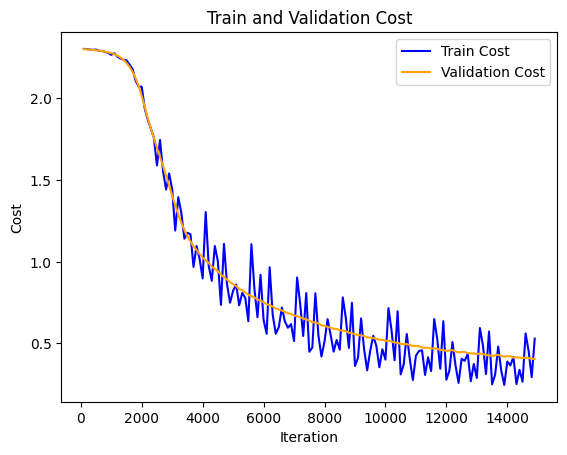


--------Batch size:64 Lambd:0.05--------
{'loss_train': 2.3033196632221067, 'cost_validation': 2.3015142621737263, 'epoch': 1, 'iteration': 100}
{'loss_train': 2.3010815369724495, 'cost_validation': 2.300285435773919, 'epoch': 1, 'iteration': 200}
{'loss_train': 2.3024628210803004, 'cost_validation': 2.2988752051955297, 'epoch': 1, 'iteration': 300}
{'loss_train': 2.2959799911279744, 'cost_validation': 2.297346070371188, 'epoch': 1, 'iteration': 400}
{'loss_train': 2.2949171050382287, 'cost_validation': 2.2954973585047487, 'epoch': 1, 'iteration': 500}
{'loss_train': 2.2894125705332162, 'cost_validation': 2.293275047885058, 'epoch': 1, 'iteration': 600}
{'loss_train': 2.289062791007115, 'cost_validation': 2.290844880348616, 'epoch': 1, 'iteration': 700}
{'loss_train': 2.2902563628993375, 'cost_validation': 2.2881176863708603, 'epoch': 2, 'iteration': 800}
{'loss_train': 2.282278540856173, 'cost_validation': 2.2846023746420103, 'epoch': 2, 'iteration': 900}
{'loss_train': 2.28375535568

<ipython-input-4-a770683401a0>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions  = np.sum(predictions == true_labels)


Test Set Accuracy for batch_size=64, use_batchnorm=False: 0.0'


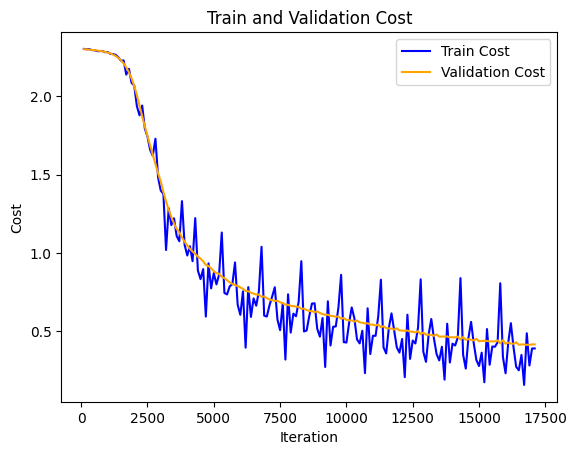


--------Batch size:128 Lambd:0--------
{'loss_train': 2.3013999518360495, 'cost_validation': 2.301504267928715, 'epoch': 1, 'iteration': 100}
{'loss_train': 2.3004520201779255, 'cost_validation': 2.300073448532918, 'epoch': 1, 'iteration': 200}
{'loss_train': 2.2980556568127524, 'cost_validation': 2.2983754268641206, 'epoch': 1, 'iteration': 300}
{'loss_train': 2.2989672741262845, 'cost_validation': 2.2966748237562205, 'epoch': 2, 'iteration': 400}
{'loss_train': 2.2952499056536766, 'cost_validation': 2.294725038413795, 'epoch': 2, 'iteration': 500}
{'loss_train': 2.2902218593892885, 'cost_validation': 2.29233964810925, 'epoch': 2, 'iteration': 600}
{'loss_train': 2.2856758136715243, 'cost_validation': 2.289435314609346, 'epoch': 2, 'iteration': 700}
{'loss_train': 2.292260391646873, 'cost_validation': 2.2861425754829785, 'epoch': 3, 'iteration': 800}
{'loss_train': 2.284638714379243, 'cost_validation': 2.282061164995035, 'epoch': 3, 'iteration': 900}
{'loss_train': 2.276096152266825,

<ipython-input-4-a770683401a0>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions  = np.sum(predictions == true_labels)


Test Set Accuracy for batch_size=128, use_batchnorm=False: 0.0'


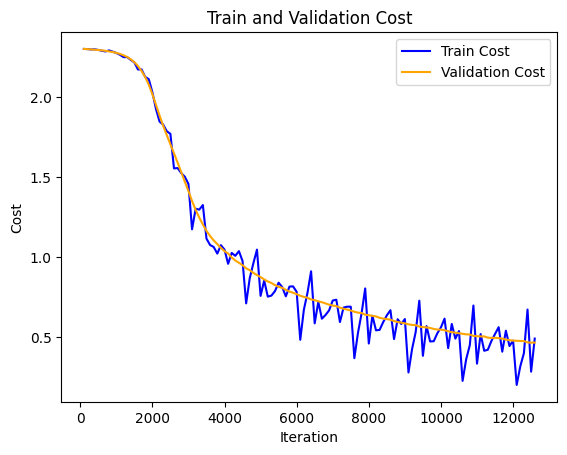


--------Batch size:128 Lambd:0.05--------
{'loss_train': 2.302176867088843, 'cost_validation': 2.3015130365011425, 'epoch': 1, 'iteration': 100}
{'loss_train': 2.3012327520764613, 'cost_validation': 2.3000850824415124, 'epoch': 1, 'iteration': 200}
{'loss_train': 2.2988425691777707, 'cost_validation': 2.2983907120609817, 'epoch': 1, 'iteration': 300}
{'loss_train': 2.29976216245349, 'cost_validation': 2.2966957168658304, 'epoch': 2, 'iteration': 400}
{'loss_train': 2.296063729932973, 'cost_validation': 2.2947549798336464, 'epoch': 2, 'iteration': 500}
{'loss_train': 2.2910583881677837, 'cost_validation': 2.2923824192682107, 'epoch': 2, 'iteration': 600}
{'loss_train': 2.286550133253825, 'cost_validation': 2.289496240179501, 'epoch': 2, 'iteration': 700}
{'loss_train': 2.2931460345455292, 'cost_validation': 2.2862285971180776, 'epoch': 3, 'iteration': 800}
{'loss_train': 2.285575797870134, 'cost_validation': 2.282182102511564, 'epoch': 3, 'iteration': 900}
{'loss_train': 2.277139762948

<ipython-input-4-a770683401a0>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions  = np.sum(predictions == true_labels)


Test Set Accuracy for batch_size=128, use_batchnorm=False: 0.0'


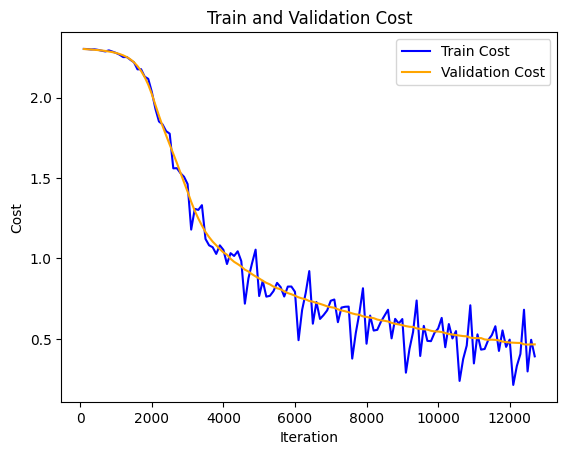


--------Batch size:256 Lambd:0--------
{'loss_train': 2.3015848147604157, 'cost_validation': 2.3015149081370865, 'epoch': 1, 'iteration': 100}
{'loss_train': 2.299129651428908, 'cost_validation': 2.2999919976274725, 'epoch': 2, 'iteration': 200}
{'loss_train': 2.299158419082593, 'cost_validation': 2.298444462169745, 'epoch': 2, 'iteration': 300}
{'loss_train': 2.2958937689552164, 'cost_validation': 2.2966930799971137, 'epoch': 3, 'iteration': 400}
{'loss_train': 2.294450948154087, 'cost_validation': 2.294719440569268, 'epoch': 3, 'iteration': 500}
{'loss_train': 2.2890814247729376, 'cost_validation': 2.2923476133979857, 'epoch': 4, 'iteration': 600}
{'loss_train': 2.2944471166473304, 'cost_validation': 2.2895749214461607, 'epoch': 4, 'iteration': 700}
{'loss_train': 2.289355617364109, 'cost_validation': 2.2862170904572086, 'epoch': 5, 'iteration': 800}
{'loss_train': 2.273393984233521, 'cost_validation': 2.28206512610599, 'epoch': 5, 'iteration': 900}
{'loss_train': 2.274941985770587,

<ipython-input-4-a770683401a0>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions  = np.sum(predictions == true_labels)


Test Set Accuracy for batch_size=256, use_batchnorm=False: 0.0'


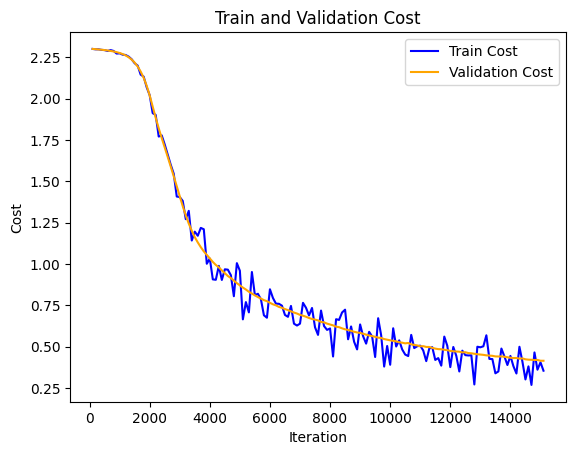


--------Batch size:256 Lambd:0.05--------
{'loss_train': 2.3019733855045614, 'cost_validation': 2.3015234701766736, 'epoch': 1, 'iteration': 100}
{'loss_train': 2.2995207773010664, 'cost_validation': 2.3000020409397486, 'epoch': 2, 'iteration': 200}
{'loss_train': 2.2995521618346912, 'cost_validation': 2.298456236325327, 'epoch': 2, 'iteration': 300}
{'loss_train': 2.296293648536922, 'cost_validation': 2.296707789634938, 'epoch': 3, 'iteration': 400}
{'loss_train': 2.294857611055669, 'cost_validation': 2.294738663647283, 'epoch': 3, 'iteration': 500}
{'loss_train': 2.2895035277157687, 'cost_validation': 2.292373446375268, 'epoch': 4, 'iteration': 600}
{'loss_train': 2.2948748244140917, 'cost_validation': 2.289609979171316, 'epoch': 4, 'iteration': 700}
{'loss_train': 2.289805927915826, 'cost_validation': 2.286264993803203, 'epoch': 5, 'iteration': 800}
{'loss_train': 2.273887819188899, 'cost_validation': 2.2821309022101617, 'epoch': 5, 'iteration': 900}
{'loss_train': 2.27546518619987

<ipython-input-4-a770683401a0>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions  = np.sum(predictions == true_labels)


Test Set Accuracy for batch_size=256, use_batchnorm=False: 0.0'


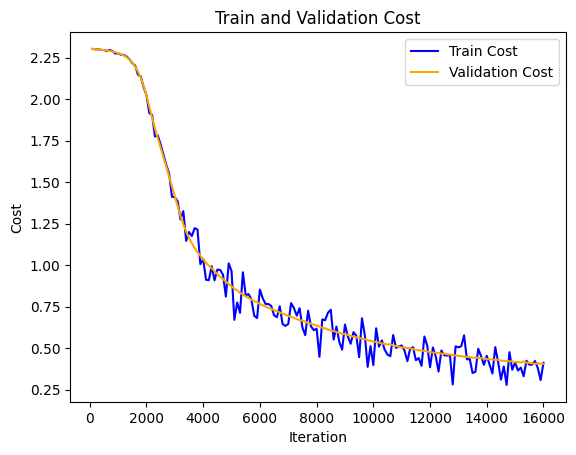


--------Batch size:512 Lambd:0--------
{'loss_train': 2.3011155642261736, 'cost_validation': 2.3015014538030116, 'epoch': 2, 'iteration': 100}
{'loss_train': 2.3004192347357253, 'cost_validation': 2.3000281602164563, 'epoch': 3, 'iteration': 200}
{'loss_train': 2.2974654419702287, 'cost_validation': 2.2984592950432994, 'epoch': 4, 'iteration': 300}
{'loss_train': 2.2975748554133135, 'cost_validation': 2.296769500478801, 'epoch': 5, 'iteration': 400}
{'loss_train': 2.294188383119132, 'cost_validation': 2.294813978028244, 'epoch': 6, 'iteration': 500}
{'loss_train': 2.2918607684602215, 'cost_validation': 2.292471425942438, 'epoch': 7, 'iteration': 600}
{'loss_train': 2.2902561677947464, 'cost_validation': 2.2897060729311525, 'epoch': 8, 'iteration': 700}
{'loss_train': 2.2878844998513976, 'cost_validation': 2.2863863418218413, 'epoch': 9, 'iteration': 800}
{'loss_train': 2.2823558050376858, 'cost_validation': 2.282284708234102, 'epoch': 10, 'iteration': 900}
{'loss_train': 2.27832528881

<ipython-input-4-a770683401a0>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions  = np.sum(predictions == true_labels)


Test Set Accuracy for batch_size=512, use_batchnorm=False: 0.0'


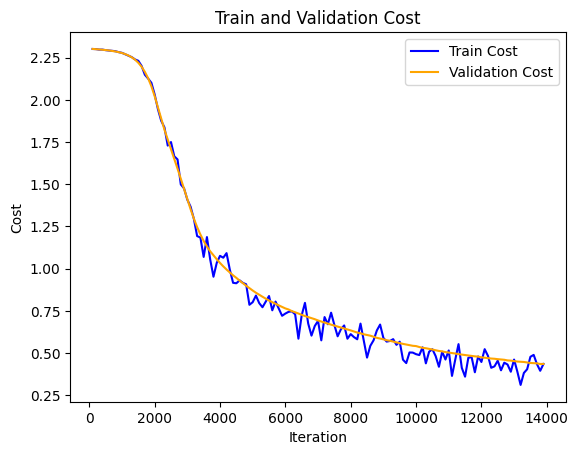


--------Batch size:512 Lambd:0.05--------
{'loss_train': 2.301309810282702, 'cost_validation': 2.301509849843358, 'epoch': 2, 'iteration': 100}
{'loss_train': 2.3006143561535737, 'cost_validation': 2.3000370382260114, 'epoch': 3, 'iteration': 200}
{'loss_train': 2.2976622349521136, 'cost_validation': 2.298469057611981, 'epoch': 4, 'iteration': 300}
{'loss_train': 2.2977740817039196, 'cost_validation': 2.296780709361121, 'epoch': 5, 'iteration': 400}
{'loss_train': 2.2943920455531788, 'cost_validation': 2.2948274142321594, 'epoch': 6, 'iteration': 500}
{'loss_train': 2.2920696986952684, 'cost_validation': 2.2924879788119017, 'epoch': 7, 'iteration': 600}
{'loss_train': 2.290472043502003, 'cost_validation': 2.289727162062845, 'epoch': 8, 'iteration': 700}
{'loss_train': 2.288110145085036, 'cost_validation': 2.286413683966454, 'epoch': 9, 'iteration': 800}
{'loss_train': 2.2825946908185055, 'cost_validation': 2.28232078705322, 'epoch': 10, 'iteration': 900}
{'loss_train': 2.2785825510779

<ipython-input-4-a770683401a0>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions  = np.sum(predictions == true_labels)


Test Set Accuracy for batch_size=512, use_batchnorm=False: 0.0'


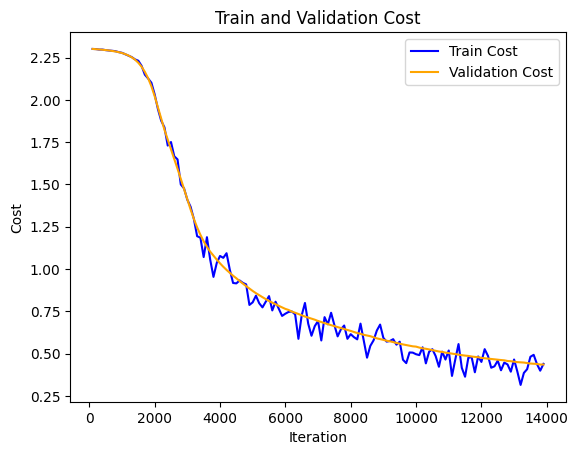

In [ ]:
main([64, 128, 256, 512])

In [ ]:
summary_df.to_csv('table_summary_without_batchnorm.csv', index=True)
summary_df

,Parameter Network,Epoch Num,Num Iteration,Costs Train,Costs Validation,Train Accuracy,Validation Accuracy
0,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",19,14900,0.530,0.40597,0.899,0.894
1,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",22,17100,0.389,0.41490,0.903,0.892
2,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",33,12600,0.490,0.46479,0.890,0.882
3,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",33,12700,0.392,0.46631,0.890,0.882
4,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",80,15100,0.355,0.41484,0.903,0.893
5,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",85,16000,0.411,0.40535,0.904,0.896
6,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",147,13900,0.435,0.43505,0.898,0.890
7,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",147,13900,0.439,0.43550,0.898,0.890



--------Batch size:64 Lambd:0--------
{'loss_train': 2.1303175533746335, 'cost_validation': 2.1869782551786834, 'epoch': 1, 'iteration': 100}
{'loss_train': 1.952248914486057, 'cost_validation': 2.047479372669585, 'epoch': 1, 'iteration': 200}
{'loss_train': 2.023562115286533, 'cost_validation': 1.9451877544839853, 'epoch': 1, 'iteration': 300}
{'loss_train': 1.9120264460492298, 'cost_validation': 1.8908666669635503, 'epoch': 1, 'iteration': 400}
{'loss_train': 1.8836052392316829, 'cost_validation': 1.8380515074561101, 'epoch': 1, 'iteration': 500}
{'loss_train': 1.7693176798209649, 'cost_validation': 1.803952289155981, 'epoch': 1, 'iteration': 600}
{'loss_train': 1.7045055261629574, 'cost_validation': 1.7731530651907645, 'epoch': 1, 'iteration': 700}
{'loss_train': 1.8086588223074371, 'cost_validation': 1.7324673230013898, 'epoch': 2, 'iteration': 800}
{'loss_train': 1.6787516866096657, 'cost_validation': 1.7078924938876527, 'epoch': 2, 'iteration': 900}
{'loss_train': 1.647764676869

<ipython-input-4-a770683401a0>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions  = np.sum(predictions == true_labels)


Test Set Accuracy for batch_size=64, use_batchnorm=True: 0.0'


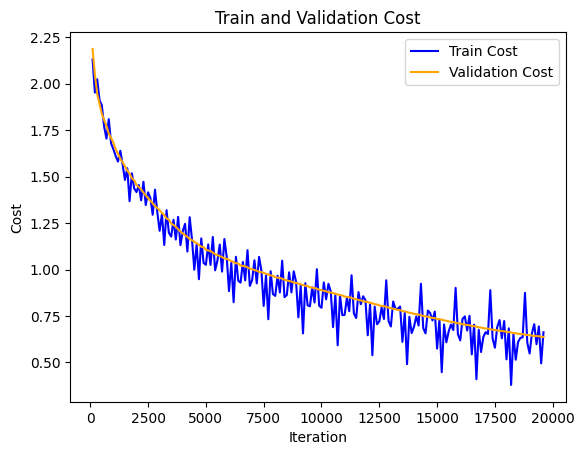


--------Batch size:64 Lambd:0.05--------
{'loss_train': 2.132448414601402, 'cost_validation': 2.187147531623637, 'epoch': 1, 'iteration': 100}
{'loss_train': 1.9525421335194875, 'cost_validation': 2.0477408058269213, 'epoch': 1, 'iteration': 200}
{'loss_train': 2.0270906587678903, 'cost_validation': 1.9456567431169085, 'epoch': 1, 'iteration': 300}
{'loss_train': 1.9140990666677136, 'cost_validation': 1.890827785668438, 'epoch': 1, 'iteration': 400}
{'loss_train': 1.8861405504225288, 'cost_validation': 1.8382174866447072, 'epoch': 1, 'iteration': 500}
{'loss_train': 1.7719829300852796, 'cost_validation': 1.8041528773153164, 'epoch': 1, 'iteration': 600}
{'loss_train': 1.7082022395949972, 'cost_validation': 1.7735819090823437, 'epoch': 1, 'iteration': 700}
{'loss_train': 1.8129433281927414, 'cost_validation': 1.733165503496053, 'epoch': 2, 'iteration': 800}
{'loss_train': 1.683846146341899, 'cost_validation': 1.7089889625181205, 'epoch': 2, 'iteration': 900}
{'loss_train': 1.6538817664

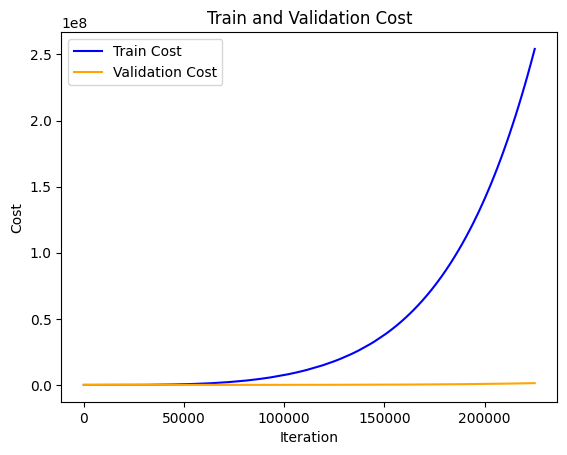


--------Batch size:128 Lambd:0--------
{'loss_train': 2.167866104844782, 'cost_validation': 2.1853815284961415, 'epoch': 1, 'iteration': 100}
{'loss_train': 2.1187757884137657, 'cost_validation': 2.043288861796636, 'epoch': 1, 'iteration': 200}
{'loss_train': 1.9315530919867472, 'cost_validation': 1.9415066556649396, 'epoch': 1, 'iteration': 300}
{'loss_train': 1.9541068273246178, 'cost_validation': 1.8756495781952562, 'epoch': 2, 'iteration': 400}
{'loss_train': 1.821793086602804, 'cost_validation': 1.836679785214622, 'epoch': 2, 'iteration': 500}
{'loss_train': 1.738348698188112, 'cost_validation': 1.7902998724207317, 'epoch': 2, 'iteration': 600}
{'loss_train': 1.7173836515567964, 'cost_validation': 1.7496503029984058, 'epoch': 2, 'iteration': 700}
{'loss_train': 1.7171919914158278, 'cost_validation': 1.7077689876159523, 'epoch': 3, 'iteration': 800}
{'loss_train': 1.6731828219844624, 'cost_validation': 1.6678177585952505, 'epoch': 3, 'iteration': 900}
{'loss_train': 1.643488299849

<ipython-input-4-a770683401a0>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions  = np.sum(predictions == true_labels)


Test Set Accuracy for batch_size=128, use_batchnorm=True: 0.0'


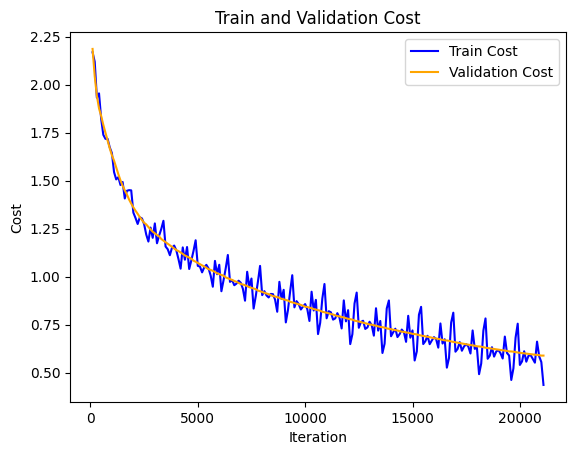


--------Batch size:128 Lambd:0.05--------
{'loss_train': 2.168638126193564, 'cost_validation': 2.185395356430054, 'epoch': 1, 'iteration': 100}
{'loss_train': 2.1189856761278274, 'cost_validation': 2.0432602615654067, 'epoch': 1, 'iteration': 200}
{'loss_train': 1.9332315482019777, 'cost_validation': 1.9414739208732466, 'epoch': 1, 'iteration': 300}
{'loss_train': 1.9550957002113436, 'cost_validation': 1.8759947051632675, 'epoch': 2, 'iteration': 400}
{'loss_train': 1.823163625956161, 'cost_validation': 1.8369089953780362, 'epoch': 2, 'iteration': 500}
{'loss_train': 1.7402309919068544, 'cost_validation': 1.7906516457813835, 'epoch': 2, 'iteration': 600}
{'loss_train': 1.7194271450478806, 'cost_validation': 1.7499676733968426, 'epoch': 2, 'iteration': 700}
{'loss_train': 1.7195228408354448, 'cost_validation': 1.7083081297143032, 'epoch': 3, 'iteration': 800}
{'loss_train': 1.675766566925507, 'cost_validation': 1.66850255727673, 'epoch': 3, 'iteration': 900}
{'loss_train': 1.6464757115

<ipython-input-4-a770683401a0>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions  = np.sum(predictions == true_labels)


Test Set Accuracy for batch_size=128, use_batchnorm=True: 0.0'


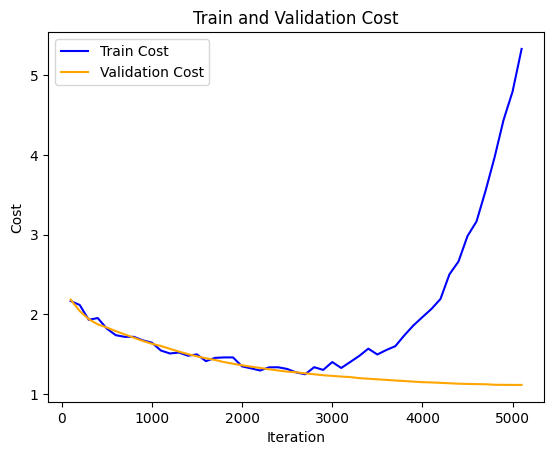


--------Batch size:256 Lambd:0--------
{'loss_train': 2.2282343877312853, 'cost_validation': 2.195095397093169, 'epoch': 1, 'iteration': 100}
{'loss_train': 2.0456458244242293, 'cost_validation': 2.052366348487188, 'epoch': 2, 'iteration': 200}
{'loss_train': 1.9830350646475958, 'cost_validation': 1.9553094798194033, 'epoch': 2, 'iteration': 300}
{'loss_train': 1.861264727092963, 'cost_validation': 1.8928837716937748, 'epoch': 3, 'iteration': 400}
{'loss_train': 1.8341587235829921, 'cost_validation': 1.8473693780141935, 'epoch': 3, 'iteration': 500}
{'loss_train': 1.7842272258166043, 'cost_validation': 1.8088926867282464, 'epoch': 4, 'iteration': 600}
{'loss_train': 1.8415657136996828, 'cost_validation': 1.766352461160609, 'epoch': 4, 'iteration': 700}
{'loss_train': 1.7369844705042778, 'cost_validation': 1.7377219527637198, 'epoch': 5, 'iteration': 800}
{'loss_train': 1.6922363222572798, 'cost_validation': 1.709378767054647, 'epoch': 5, 'iteration': 900}
{'loss_train': 1.654371042138

<ipython-input-4-a770683401a0>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions  = np.sum(predictions == true_labels)


Test Set Accuracy for batch_size=256, use_batchnorm=True: 0.0'


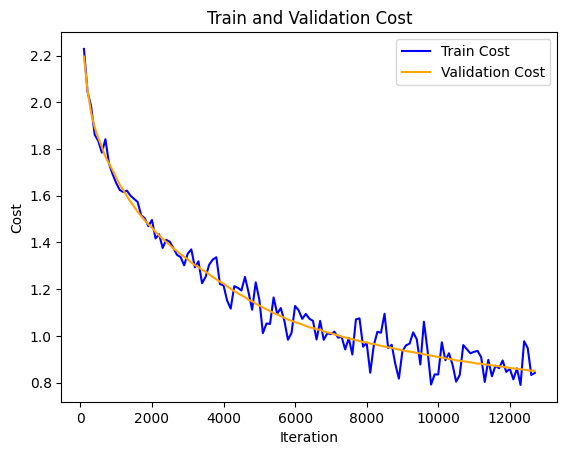


--------Batch size:256 Lambd:0.05--------
{'loss_train': 2.2321279730484096, 'cost_validation': 2.1950203016602017, 'epoch': 1, 'iteration': 100}
{'loss_train': 2.046547087319884, 'cost_validation': 2.052489725251153, 'epoch': 2, 'iteration': 200}
{'loss_train': 1.983920871272962, 'cost_validation': 1.9555834753952235, 'epoch': 2, 'iteration': 300}
{'loss_train': 1.861946819032779, 'cost_validation': 1.892857414424017, 'epoch': 3, 'iteration': 400}
{'loss_train': 1.8349456975428868, 'cost_validation': 1.8474982740962222, 'epoch': 3, 'iteration': 500}
{'loss_train': 1.7849811547464352, 'cost_validation': 1.80914127019065, 'epoch': 4, 'iteration': 600}
{'loss_train': 1.842701501103384, 'cost_validation': 1.7667375849001417, 'epoch': 4, 'iteration': 700}
{'loss_train': 1.738335801988939, 'cost_validation': 1.7382158734104236, 'epoch': 5, 'iteration': 800}
{'loss_train': 1.693775622417428, 'cost_validation': 1.709921343825767, 'epoch': 5, 'iteration': 900}
{'loss_train': 1.656224779764581

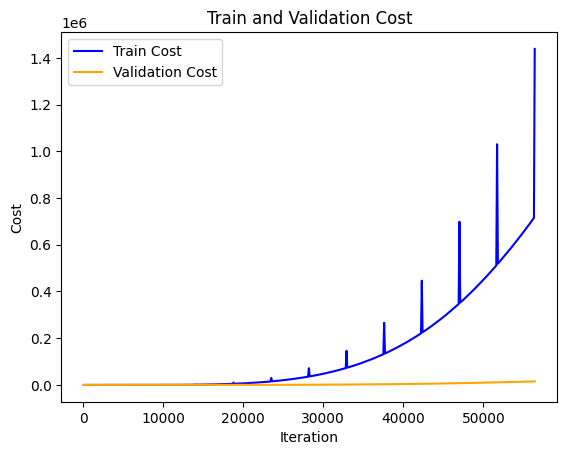


--------Batch size:512 Lambd:0--------
{'loss_train': 2.1974790530756434, 'cost_validation': 2.1909940142596755, 'epoch': 2, 'iteration': 100}
{'loss_train': 2.057323104874234, 'cost_validation': 2.058149744181968, 'epoch': 3, 'iteration': 200}
{'loss_train': 1.9404344564889398, 'cost_validation': 1.9544615723035141, 'epoch': 4, 'iteration': 300}
{'loss_train': 1.8936359625260701, 'cost_validation': 1.8956573905999627, 'epoch': 5, 'iteration': 400}
{'loss_train': 1.8136990160412936, 'cost_validation': 1.849634946007903, 'epoch': 6, 'iteration': 500}
{'loss_train': 1.791875782262554, 'cost_validation': 1.8104265432687219, 'epoch': 7, 'iteration': 600}
{'loss_train': 1.7841509139268126, 'cost_validation': 1.7764749863619826, 'epoch': 8, 'iteration': 700}
{'loss_train': 1.7452448301375334, 'cost_validation': 1.7413137455692582, 'epoch': 9, 'iteration': 800}
{'loss_train': 1.7212452383276275, 'cost_validation': 1.7118134265700913, 'epoch': 10, 'iteration': 900}
{'loss_train': 1.6868371916

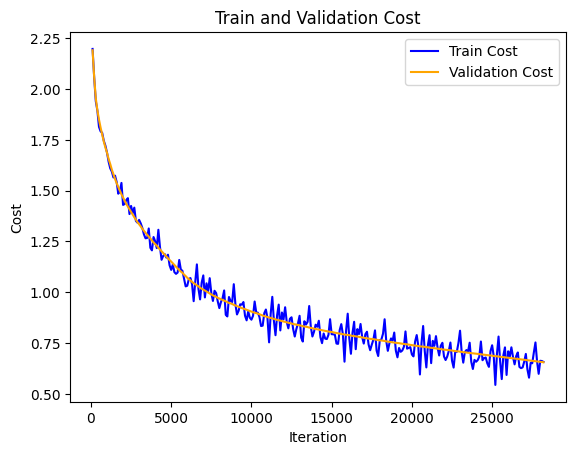


--------Batch size:512 Lambd:0.05--------
{'loss_train': 2.197262441626557, 'cost_validation': 2.1909474794941253, 'epoch': 2, 'iteration': 100}
{'loss_train': 2.0573653240892464, 'cost_validation': 2.0579253264170014, 'epoch': 3, 'iteration': 200}
{'loss_train': 1.9406989804645378, 'cost_validation': 1.9542509610899117, 'epoch': 4, 'iteration': 300}
{'loss_train': 1.893343400454091, 'cost_validation': 1.8951809171711886, 'epoch': 5, 'iteration': 400}
{'loss_train': 1.813607568180686, 'cost_validation': 1.849292321941176, 'epoch': 6, 'iteration': 500}
{'loss_train': 1.7918436344797377, 'cost_validation': 1.8100511760547233, 'epoch': 7, 'iteration': 600}
{'loss_train': 1.7841618879912773, 'cost_validation': 1.776090610780188, 'epoch': 8, 'iteration': 700}
{'loss_train': 1.7452611158182634, 'cost_validation': 1.7408482597072539, 'epoch': 9, 'iteration': 800}
{'loss_train': 1.7211378729536242, 'cost_validation': 1.7113163501646853, 'epoch': 10, 'iteration': 900}
{'loss_train': 1.68688494

<ipython-input-4-a770683401a0>:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions  = np.sum(predictions == true_labels)


Test Set Accuracy for batch_size=512, use_batchnorm=True: 0.0'


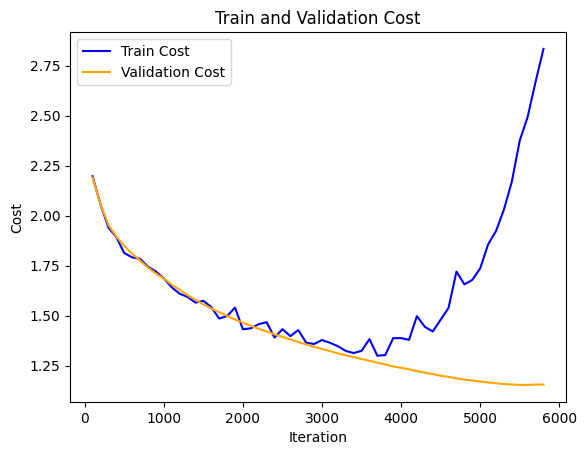

In [ ]:
main([64, 128, 256, 512], use_batchnorm=True)

In [ ]:
summary_df.to_csv('table_summary.csv', index=True)
summary_df

,Parameter Network,Epoch Num,Num Iteration,Costs Train,Costs Validation,Train Accuracy,Validation Accuracy
0,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",19,14900,0.530,0.40597,0.899,0.894
1,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",22,17100,0.389,0.41490,0.903,0.892
2,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",33,12600,0.490,0.46479,0.890,0.882
3,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",33,12700,0.392,0.46631,0.890,0.882
4,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",80,15100,0.355,0.41484,0.903,0.893
5,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",85,16000,0.411,0.40535,0.904,0.896
6,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",147,13900,0.435,0.43505,0.898,0.890
7,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",147,13900,0.439,0.43550,0.898,0.890
8,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",26,19600,0.662,0.63738,0.826,0.823
9,"{'W1': array([[ 1.69542369e-03, -9.82185526e-0...",56,21100,0.437,0.58940,0.841,0.840
